In [1]:
#import needed modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [2]:
#load the data already in keras. 
#ELse data can be get at Yann Lecun website: http://yann.lecun.com/exdb/mnist/ (
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
#@title Double-click to see a solution to Task 1. 
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
print(x_train_normalized[2900][10]) # Output a normalized row

[0.         0.         0.         0.         0.         0.         0.         0.55294118 1.         0.66666667 0.11372549 0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]


In [4]:
#@title Define the plotting function
def plot_curve(title,epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")
  plt.title(title)

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [5]:
d_optimizer={"SGD" : lambda  l: tf.keras.optimizers.SGD(learning_rate=l),
"RMSprop" : lambda  l: tf.keras.optimizers.RMSprop(learning_rate=l),
"Adam" : lambda  l: tf.keras.optimizers.Adam(learning_rate=l),
"AdamW" : lambda  l: tf.keras.optimizers.AdamW(learning_rate=l),
"Adadelta" : lambda  l: tf.keras.optimizers.Adadelta(learning_rate=l),
"Adagrad" : lambda  l: tf.keras.optimizers.Adagrad(learning_rate=l),
"Adamax" : lambda  l: tf.keras.optimizers.Adamax(learning_rate=l),
"Adafactor" : lambda  l: tf.keras.optimizers.Adafactor(learning_rate=l),
"Nadam" : lambda  l: tf.keras.optimizers.Nadam(learning_rate=l),
"Ftrl" : lambda  l: tf.keras.optimizers.Ftrl(learning_rate=l)}

def create_optimizer(name, learning_rate):
    return d_optimizer.get(name)(learning_rate)

In [6]:
def create_layer(k, dict_layer,model):
    param = dict_layer.get(k)
    model.add(tf.keras.layers.Dense(units=param.get("nb_node"), activation=param.get("activation")))
    # Define a dropout regularization layer. 
    model.add(tf.keras.layers.Dropout(rate=param.get("drop_out_rate")))
    return model

def create_model(dict_layer:dict, optimizer:str, loss:str, learning_rate, metrics:list):
    """Create and compile a deep neural net."""
    """key of dict_layer must be in the form {1 : {param1}, 2 : {param1} 
        with 1 being layer 1, 2 being layer 2, etc. param has the key values
        "activation" : "activation_function_name"
        "nb_node" : nb_node
        "drop_out_rate" : drop_out_rate_value (not use for the last layer)  """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    # The features are stored in a two-dimensional 28X28 array. 
    # Flatten that two-dimensional array into a one-dimensional 
    # 784-element array.
    for k in range(1,len(dict_layer)):
        model=create_layer(k,dict_layer,model)
    param=dict_layer.get(len(dict_layer))
    # Define the output layer. It had 10 units because we have 10 classes
    model.add(tf.keras.layers.Dense(param.get("nb_node"), activation=param.get("activation")))     

    # compile the model to use it. We use Adam as optimizer and sparse_categorical_crossentropy because
    # we have a multi-class classification
    model.compile(optimizer=create_optimizer(optimizer,learning_rate=learning_rate),
                    loss=loss,
                    metrics=metrics)
    return model    

In [7]:
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1, verbose=2):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split, verbose = verbose)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return model, epochs, hist    

In [8]:
def test_model(dict_layer, optimizer, loss, learning_rate, metrics,
                   epochs, batch_size, validation_split, verbose):
    my_model = create_model(dict_layer = dict_layer, 
                            optimizer = "Adam",
                            loss="sparse_categorical_crossentropy",
                            learning_rate=learning_rate,
                            metrics=['accuracy'])
    # Train the model on the normalized training set.
    my_model, epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                               epochs, batch_size, validation_split, verbose = 0)

    # Plot a graph of the metric vs. epochs.
    title = ""
    for v in dict_layer.values():
        title += v.get("activation") + " + "
    title=title[:-2]
    list_of_metrics_to_plot = ['accuracy']
    print("\n ------------ ",title," ------------" )
    plot_curve(title,epochs, hist, list_of_metrics_to_plot)

    # Evaluate against the test set.
    print("Evaluate the new model against the test set:")
    my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)


 ------------  softmax   ------------
Evaluate the new model against the test set:
10/10 [==============================] - 0s 4ms/step - loss: 0.2650 - accuracy: 0.9273

 ------------  relu + softmax   ------------
Evaluate the new model against the test set:
10/10 [==============================] - 0s 7ms/step - loss: 0.0854 - accuracy: 0.9802

 ------------  swish + softmax   ------------
Evaluate the new model against the test set:
10/10 [==============================] - 0s 5ms/step - loss: 0.0871 - accuracy: 0.9785

 ------------  relu + swish + softmax   ------------
Evaluate the new model against the test set:
10/10 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9827


[None, None, None, None]

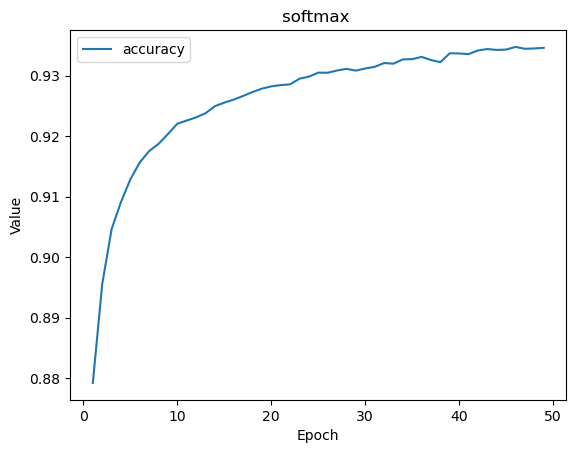

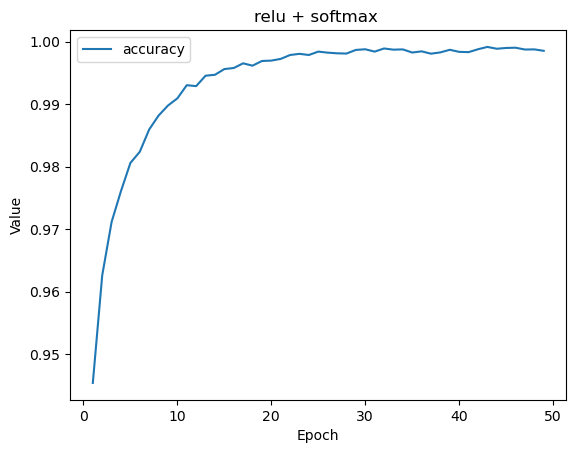

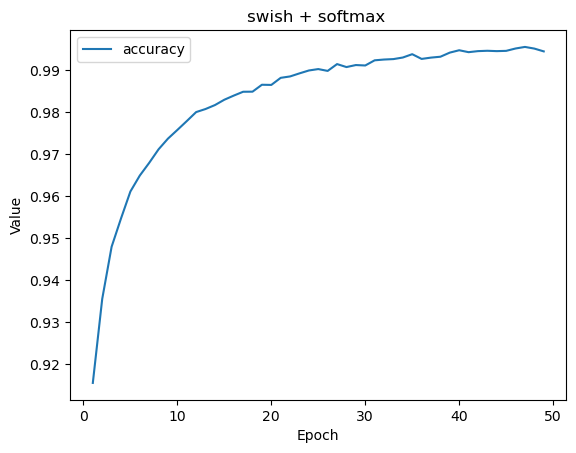

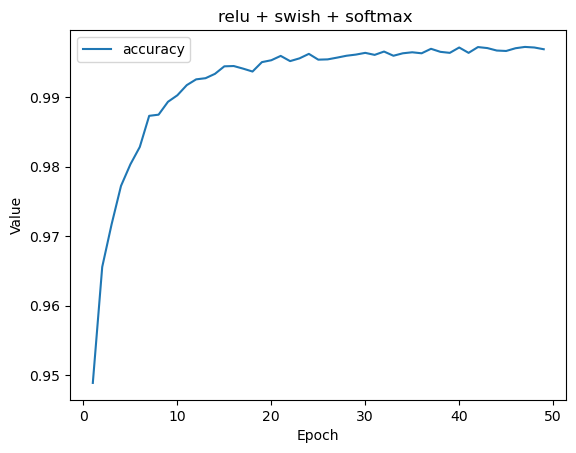

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 1000
validation_split = 0.2

# Establish the model's topography.
#my_model = create_model(learning_rate)

relu = {"activation" : "relu",
           "nb_node" : 392,
           "drop_out_rate" : 0.2}    
swish = {"activation" : "swish",
           "nb_node" : 98,
           "drop_out_rate" : 0.2}    
softmax = {"activation" : "softmax",
           "nb_node" : 10}    
 #(dict_layer,optimizer:str, loss:str, learning_rate, metrics:list)
arch = [{1:softmax},{1:relu,2:softmax},{1 : swish,2:softmax},{1 : relu,2:swish, 3:softmax}]    

traintest = lambda dc : test_model(dict_layer = dc, optimizer = "Adam",
                                loss="sparse_categorical_crossentropy",
                                learning_rate=learning_rate,metrics=['accuracy'],
                                epochs=epochs, batch_size = batch_size, 
                                validation_split = validation_split,verbose = 0)
[traintest(dc) for dc in arch] 

We see that softmax alone works well but adding another layer is more efficient. Relu is most efficient as first layer than swish. The most efficient is the neural network with the most layer but relu with softmax could be enough as the accuracy are almost the same